In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install node2vec

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from collections import Counter

# **Positive Negative Sample Creation**

In [ ]:
G = nx.read_graphml("/content/drive/MyDrive/MS Thesis/Final/graph.graphml")
DEPOD = pd.read_csv('/content/drive/MyDrive/MS Thesis/Final/DEPOD_2019/phosphatase_substrate_dephosphosite.csv')
phosphoSitePlus = pd.read_csv('/content/drive/MyDrive/MS Thesis/Final/PhosphoSitePlus_2025/kinase_substrate_phosphosite.csv')

remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('relationship') == 'P-Psite']
G.remove_edges_from(remove)

a = list(set(DEPOD['Phosphatase']))
b = list(set(phosphoSitePlus['Phosphosite']))

positive = []
negative = []

for _, row in DEPOD.iterrows():
    phosphatase = row['Phosphatase']
    substrate = row['Dephosphosite']
    positive.append({'Phosphatase': phosphatase, 'Substrate': substrate, 'label': 1})

positive_pairs = {(x['Phosphatase'], x['Substrate']) for x in positive}

while len(negative) < len(positive):
    p = np.random.choice(a)
    s = np.random.choice(b)
    if (p != s) and ((p, s) not in positive_pairs):
        negative.append({'Phosphatase': p, 'Substrate': s, 'label': 0})

dataset = pd.DataFrame(positive + negative)

# **Dimension=8**

Computing transition probabilities:   0%|          | 0/29683 [00:00<?, ?it/s]

Logistic Regression


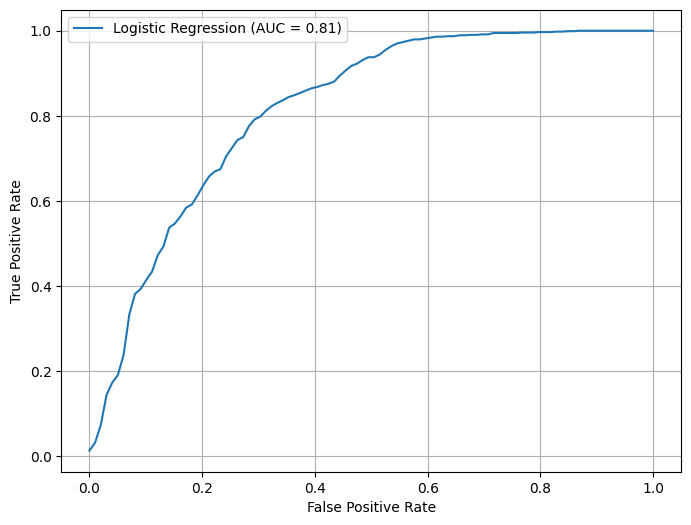

Random Forest


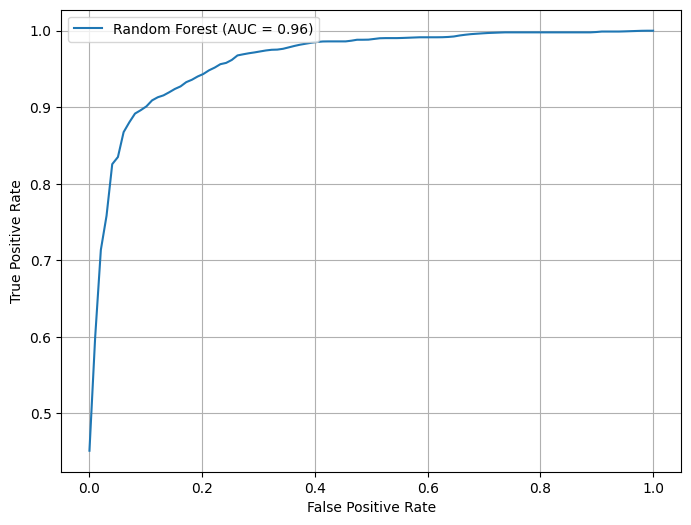

Naive Bayes


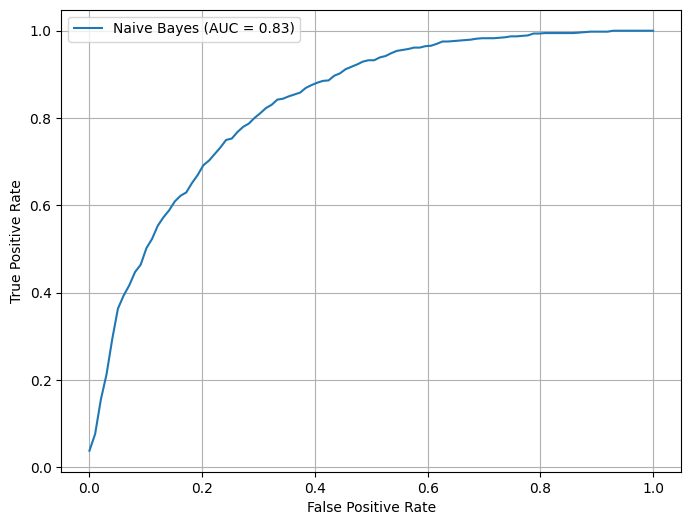

SVM


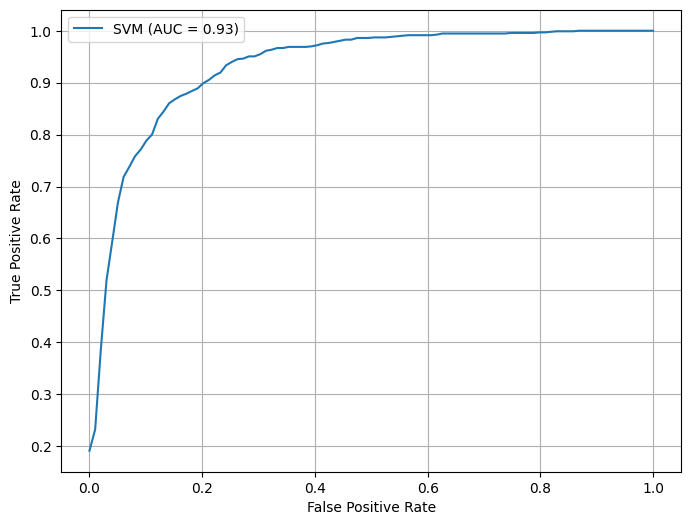

KNN


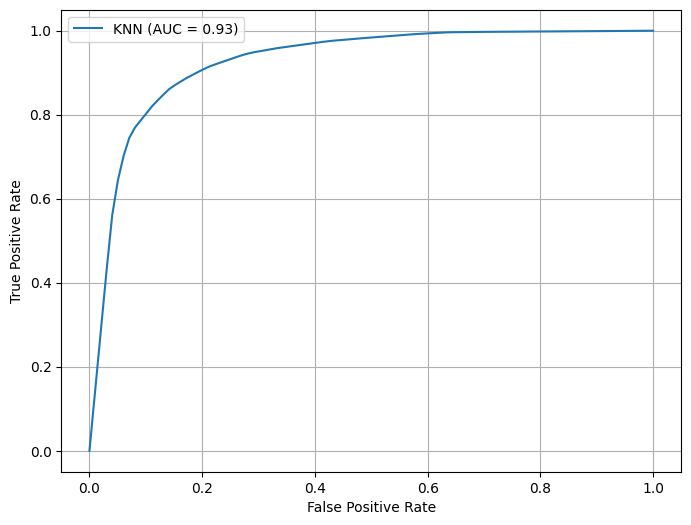

Logistic Regression
AUC:  0.8150
F1:   0.7539
ACC:  0.7460
SPEC: 0.7131
SENS: 0.7788
Random Forest
AUC:  0.9625
F1:   0.9023
ACC:  0.9023
SPEC: 0.9012
SENS: 0.9034
Naive Bayes
AUC:  0.8325
F1:   0.7556
ACC:  0.7487
SPEC: 0.7196
SENS: 0.7777
SVM
AUC:  0.9304
F1:   0.8617
ACC:  0.8571
SPEC: 0.8238
SENS: 0.8904
KNN
AUC:  0.9261
F1:   0.8521
ACC:  0.8351
SPEC: 0.7218
SENS: 0.9485


In [ ]:
d1 = dataset.copy()
node2vec = Node2Vec(G, dimensions=8, walk_length=80, num_walks=120, workers=4, seed=42)
model = node2vec.fit(window=10, min_count=1, batch_words=32)

def add_embeddings(df):
    df['p_emb'] = df['Phosphatase'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(8))
    df['s_emb'] = df['Substrate'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(8))
    return df

d1 = add_embeddings(d1)

X = np.stack(d1.apply(lambda row: np.concatenate([row['p_emb'], row['s_emb']]), axis=1))
y = d1['label'].values

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(model, X, y, kf):
    aucs, f1s, accs, specs, sens = [], [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for a, b in kf.split(X, y):
        X_train, X_test = X[a], X[b]
        y_train, y_test = y[a], y[b]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        aucs.append(auc(fpr, tpr))
        f1s.append(f1_score(y_test, y_pred))
        accs.append(accuracy_score(y_test, y_pred))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specs.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))

    return {
        'auc': np.mean(aucs),
        'f1': np.mean(f1s),
        'acc': np.mean(accs),
        'spec': np.mean(specs),
        'sens': np.mean(sens),
        'mean_fpr': mean_fpr,
        'mean_tpr': np.mean(tprs, axis=0)
    }

results = {}
for name, clf in models.items():
    print(f"{name}")
    res = evaluate(clf, X, y, kf)
    results[name] = res

    plt.figure(figsize=(8, 6))
    plt.plot(res['mean_fpr'], res['mean_tpr'], label=f"{name} (AUC = {res['auc']:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

for name, res in results.items():
    print(f"{name}")
    print(f"AUC:  {res['auc']:.4f}")
    print(f"F1:   {res['f1']:.4f}")
    print(f"ACC:  {res['acc']:.4f}")
    print(f"SPEC: {res['spec']:.4f}")
    print(f"SENS: {res['sens']:.4f}")

# **Dimension=16**

Computing transition probabilities:   0%|          | 0/29683 [00:00<?, ?it/s]

Logistic Regression


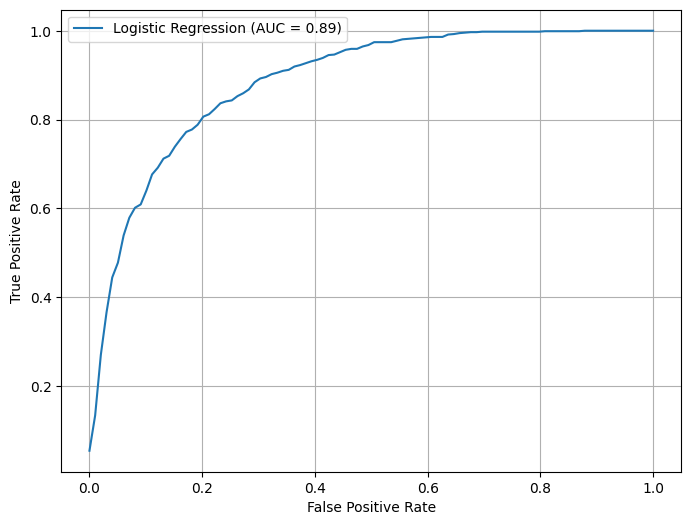

Random Forest


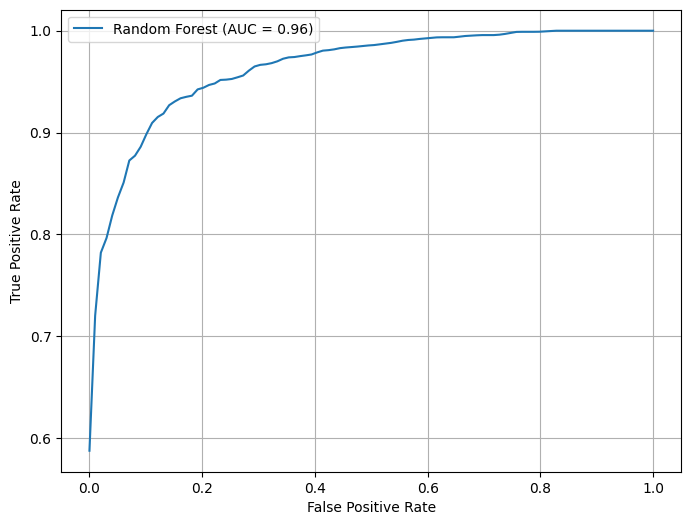

Naive Bayes


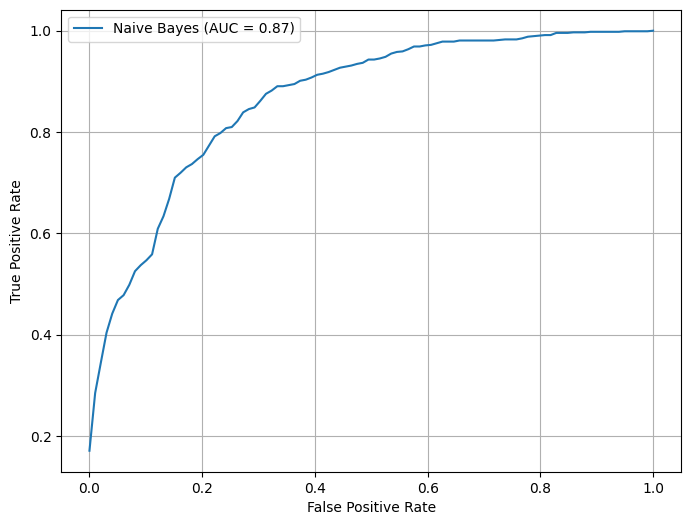

SVM


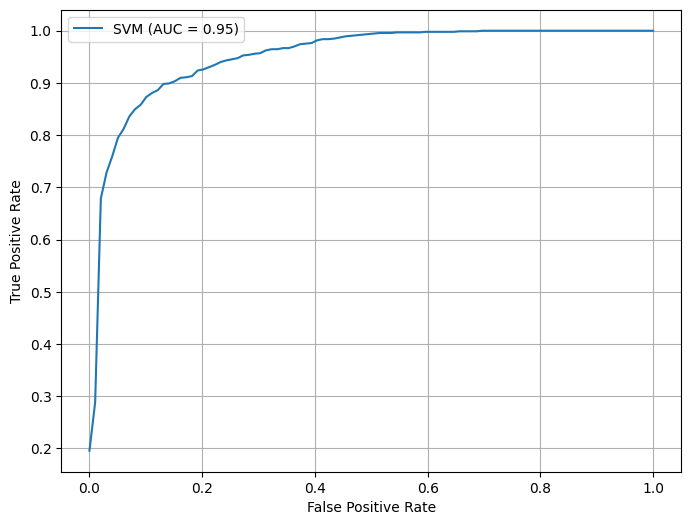

KNN


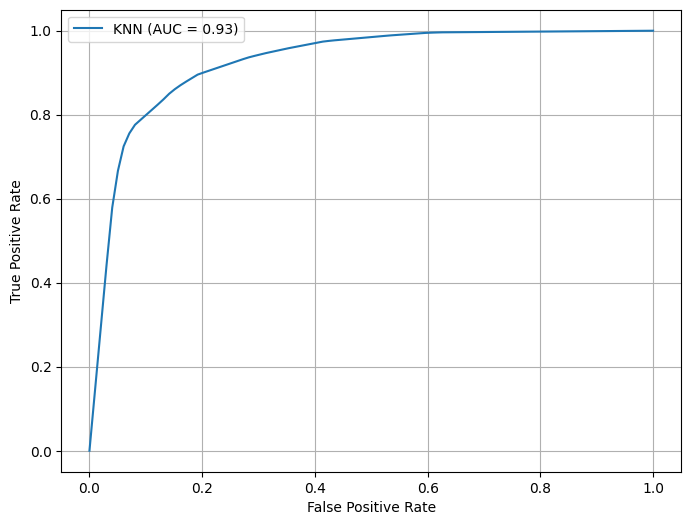

Logistic Regression
AUC:  0.8852
F1:   0.8040
ACC:  0.8018
SPEC: 0.7905
SENS: 0.8131
Random Forest
AUC:  0.9634
F1:   0.8958
ACC:  0.8969
SPEC: 0.9044
SENS: 0.8894
Naive Bayes
AUC:  0.8651
F1:   0.7875
ACC:  0.7852
SPEC: 0.7733
SENS: 0.7970
SVM
AUC:  0.9515
F1:   0.8843
ACC:  0.8829
SPEC: 0.8700
SENS: 0.8958
KNN
AUC:  0.9251
F1:   0.8489
ACC:  0.8330
SPEC: 0.7292
SENS: 0.9367


In [ ]:
d2 = dataset.copy()

node2vec = Node2Vec(G, dimensions=16, walk_length=80, num_walks=120, workers=4, seed=42)
model = node2vec.fit(window=10, min_count=1, batch_words=32)

def add_embeddings(df):
    df['p_emb'] = df['Phosphatase'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(16))
    df['s_emb'] = df['Substrate'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(16))
    return df

d2 = add_embeddings(d2)

X = np.stack(d2.apply(lambda row: np.concatenate([row['p_emb'], row['s_emb']]), axis=1))
y = d2['label'].values

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(model, X, y, kf):
    aucs, f1s, accs, specs, sens = [], [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for a, b in kf.split(X, y):
        X_train, X_test = X[a], X[b]
        y_train, y_test = y[a], y[b]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        aucs.append(auc(fpr, tpr))
        f1s.append(f1_score(y_test, y_pred))
        accs.append(accuracy_score(y_test, y_pred))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specs.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))

    return {
        'auc': np.mean(aucs),
        'f1': np.mean(f1s),
        'acc': np.mean(accs),
        'spec': np.mean(specs),
        'sens': np.mean(sens),
        'mean_fpr': mean_fpr,
        'mean_tpr': np.mean(tprs, axis=0)
    }

results = {}
for name, clf in models.items():
    print(f"{name}")
    res = evaluate(clf, X, y, kf)
    results[name] = res

    plt.figure(figsize=(8, 6))
    plt.plot(res['mean_fpr'], res['mean_tpr'], label=f"{name} (AUC = {res['auc']:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

for name, res in results.items():
    print(f"{name}")
    print(f"AUC:  {res['auc']:.4f}")
    print(f"F1:   {res['f1']:.4f}")
    print(f"ACC:  {res['acc']:.4f}")
    print(f"SPEC: {res['spec']:.4f}")
    print(f"SENS: {res['sens']:.4f}")

# **Dimension=32**

Computing transition probabilities:   0%|          | 0/29683 [00:00<?, ?it/s]

Logistic Regression


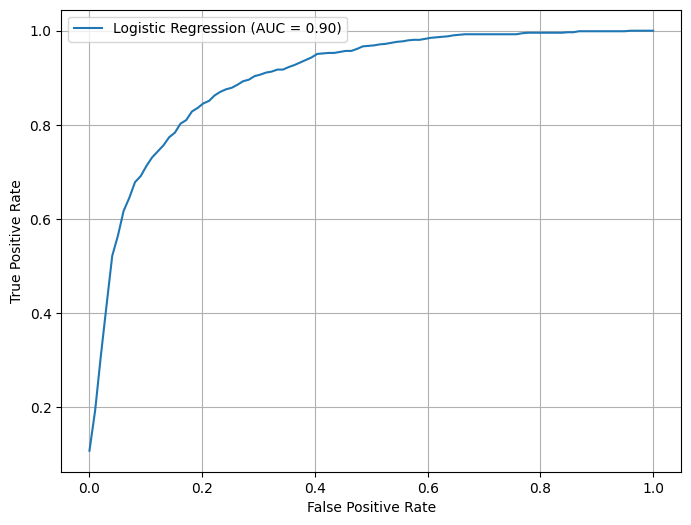

Random Forest


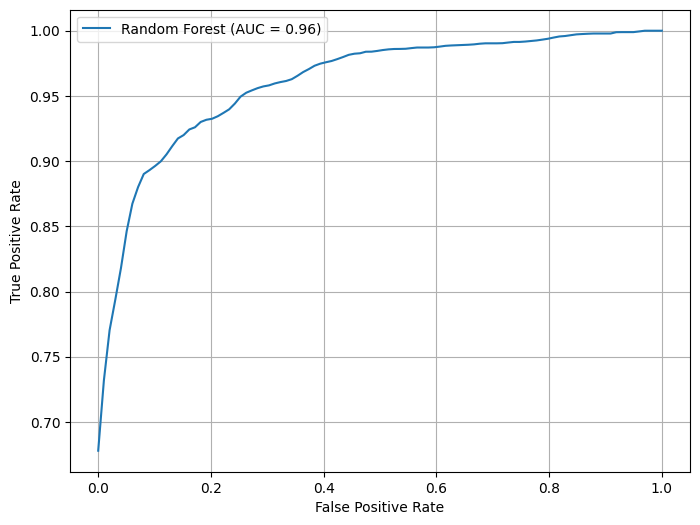

Naive Bayes


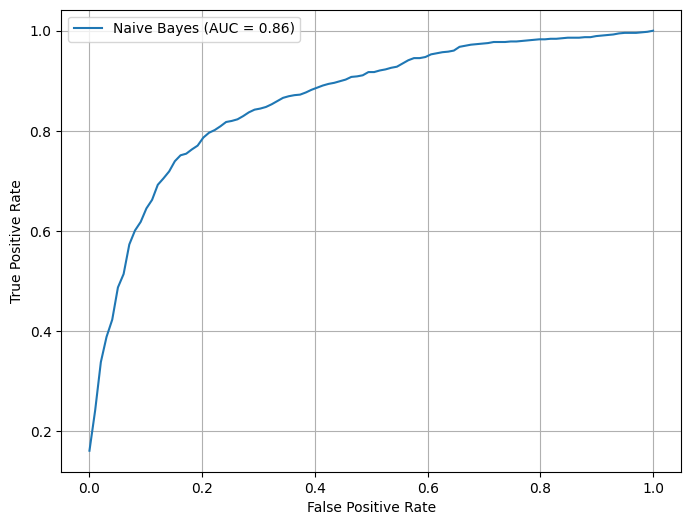

SVM


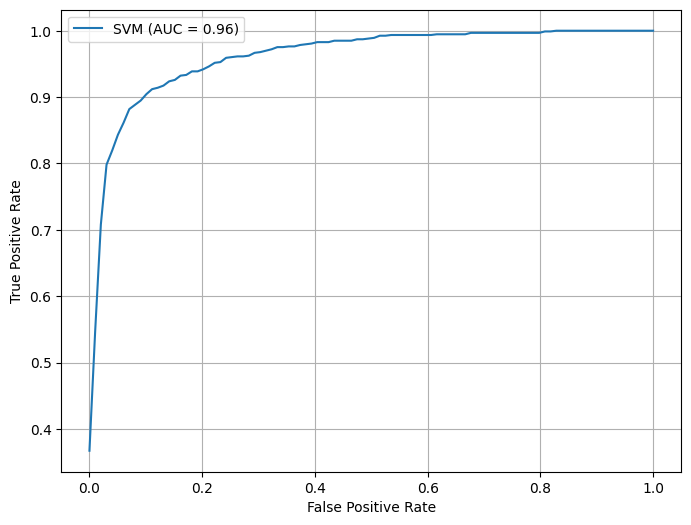

KNN


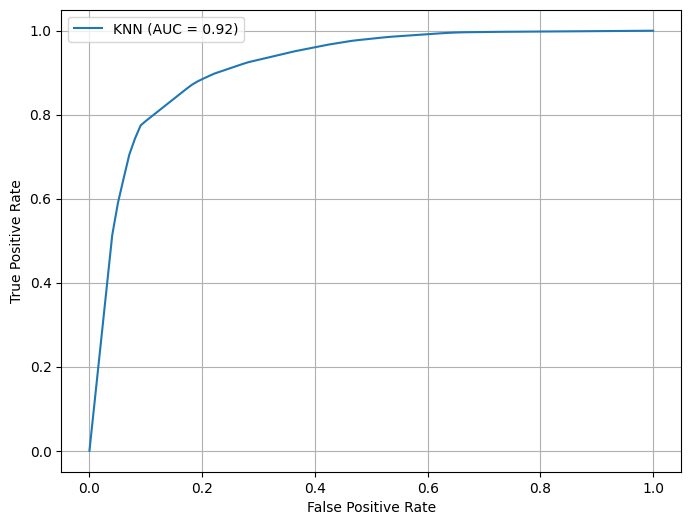

Logistic Regression
AUC:  0.8998
F1:   0.8201
ACC:  0.8196
SPEC: 0.8152
SENS: 0.8239
Random Forest
AUC:  0.9601
F1:   0.9019
ACC:  0.9050
SPEC: 0.9345
SENS: 0.8754
Naive Bayes
AUC:  0.8622
F1:   0.7863
ACC:  0.7949
SPEC: 0.8346
SENS: 0.7552
SVM
AUC:  0.9621
F1:   0.9006
ACC:  0.9012
SPEC: 0.9055
SENS: 0.8969
KNN
AUC:  0.9156
F1:   0.8261
ACC:  0.8008
SPEC: 0.6563
SENS: 0.9452


In [ ]:
d3 = dataset.copy()

node2vec = Node2Vec(G, dimensions=32, walk_length=80, num_walks=120, workers=4, seed=42)
model = node2vec.fit(window=10, min_count=1, batch_words=32)

def add_embeddings(df):
    df['p_emb'] = df['Phosphatase'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(32))
    df['s_emb'] = df['Substrate'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(32))
    return df

d3 = add_embeddings(d3)

X = np.stack(d3.apply(lambda row: np.concatenate([row['p_emb'], row['s_emb']]), axis=1))
y = d3['label'].values

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(model, X, y, kf):
    aucs, f1s, accs, specs, sens = [], [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for a, b in kf.split(X, y):
        X_train, X_test = X[a], X[b]
        y_train, y_test = y[a], y[b]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        aucs.append(auc(fpr, tpr))
        f1s.append(f1_score(y_test, y_pred))
        accs.append(accuracy_score(y_test, y_pred))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specs.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))

    return {
        'auc': np.mean(aucs),
        'f1': np.mean(f1s),
        'acc': np.mean(accs),
        'spec': np.mean(specs),
        'sens': np.mean(sens),
        'mean_fpr': mean_fpr,
        'mean_tpr': np.mean(tprs, axis=0)
    }

results = {}
for name, clf in models.items():
    print(f"{name}")
    res = evaluate(clf, X, y, kf)
    results[name] = res

    plt.figure(figsize=(8, 6))
    plt.plot(res['mean_fpr'], res['mean_tpr'], label=f"{name} (AUC = {res['auc']:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

for name, res in results.items():
    print(f"{name}")
    print(f"AUC:  {res['auc']:.4f}")
    print(f"F1:   {res['f1']:.4f}")
    print(f"ACC:  {res['acc']:.4f}")
    print(f"SPEC: {res['spec']:.4f}")
    print(f"SENS: {res['sens']:.4f}")

# **Dimension=64**

Computing transition probabilities:   0%|          | 0/29683 [00:00<?, ?it/s]

Logistic Regression


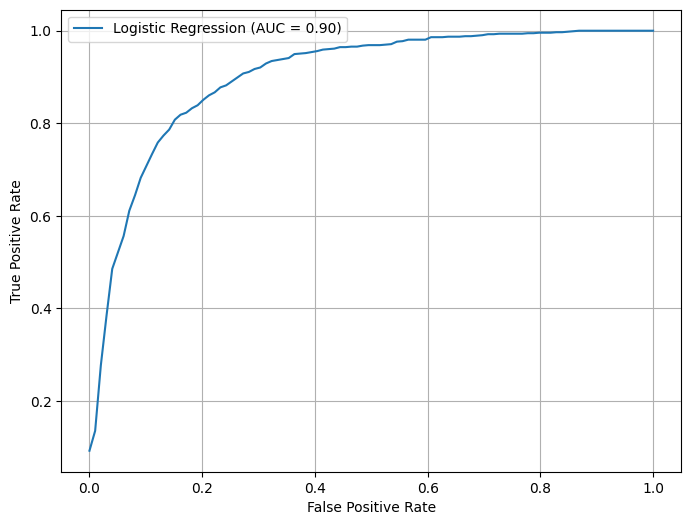

Random Forest


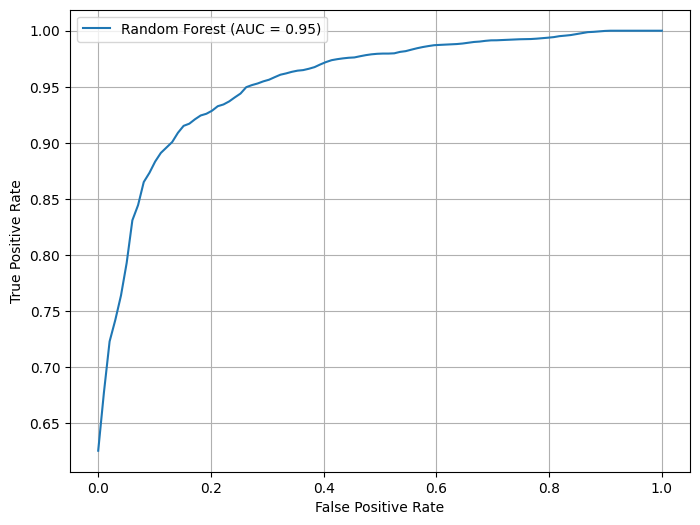

Naive Bayes


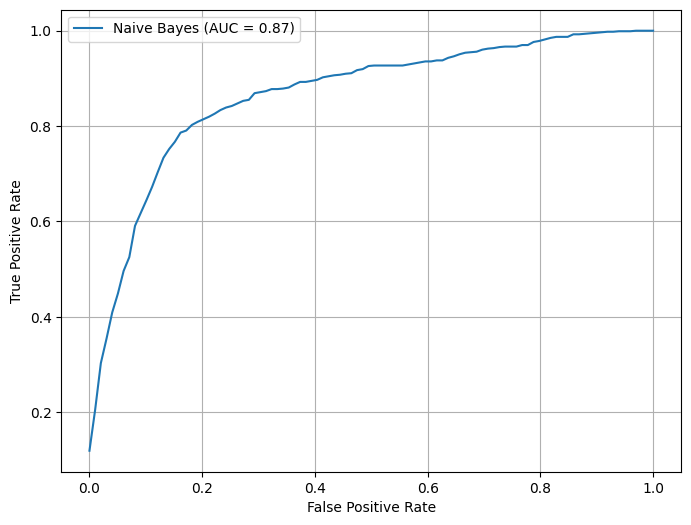

SVM


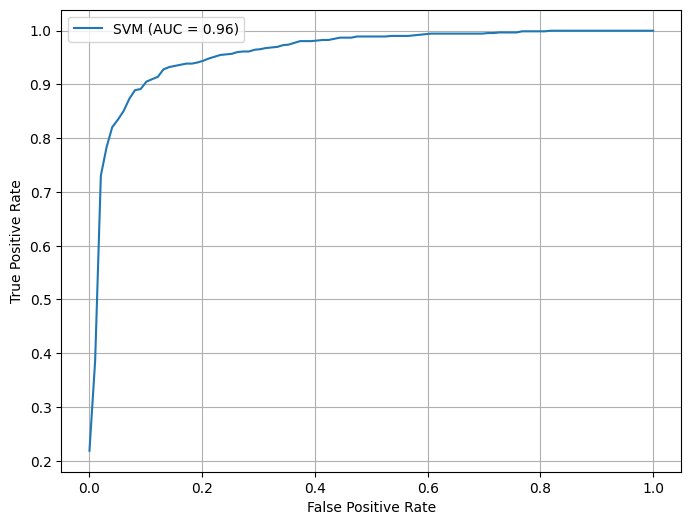

KNN


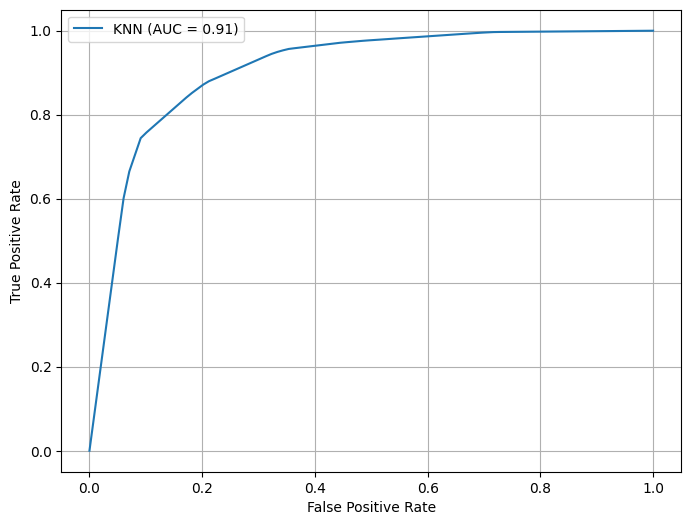

Logistic Regression
AUC:  0.9011
F1:   0.8257
ACC:  0.8238
SPEC: 0.8109
SENS: 0.8368
Random Forest
AUC:  0.9540
F1:   0.8893
ACC:  0.8915
SPEC: 0.9087
SENS: 0.8744
Naive Bayes
AUC:  0.8652
F1:   0.7909
ACC:  0.8040
SPEC: 0.8636
SENS: 0.7444
SVM
AUC:  0.9598
F1:   0.9009
ACC:  0.9012
SPEC: 0.9023
SENS: 0.9002
KNN
AUC:  0.9067
F1:   0.8318
ACC:  0.8072
SPEC: 0.6606
SENS: 0.9538


In [ ]:
d4 = dataset.copy()
node2vec = Node2Vec(G, dimensions=64, walk_length=80, num_walks=120, workers=4, seed=42)
model = node2vec.fit(window=10, min_count=1, batch_words=32)

def add_embeddings(df):
    df['p_emb'] = df['Phosphatase'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(64))
    df['s_emb'] = df['Substrate'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(64))
    return df

d4 = add_embeddings(d4)

X = np.stack(d4.apply(lambda row: np.concatenate([row['p_emb'], row['s_emb']]), axis=1))
y = d4['label'].values

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(model, X, y, kf):
    aucs, f1s, accs, specs, sens = [], [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for a, b in kf.split(X, y):
        X_train, X_test = X[a], X[b]
        y_train, y_test = y[a], y[b]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        aucs.append(auc(fpr, tpr))
        f1s.append(f1_score(y_test, y_pred))
        accs.append(accuracy_score(y_test, y_pred))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specs.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))

    return {
        'auc': np.mean(aucs),
        'f1': np.mean(f1s),
        'acc': np.mean(accs),
        'spec': np.mean(specs),
        'sens': np.mean(sens),
        'mean_fpr': mean_fpr,
        'mean_tpr': np.mean(tprs, axis=0)
    }

results = {}
for name, clf in models.items():
    print(f"{name}")
    res = evaluate(clf, X, y, kf)
    results[name] = res

    plt.figure(figsize=(8, 6))
    plt.plot(res['mean_fpr'], res['mean_tpr'], label=f"{name} (AUC = {res['auc']:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

for name, res in results.items():
    print(f"{name}")
    print(f"AUC:  {res['auc']:.4f}")
    print(f"F1:   {res['f1']:.4f}")
    print(f"ACC:  {res['acc']:.4f}")
    print(f"SPEC: {res['spec']:.4f}")
    print(f"SENS: {res['sens']:.4f}")

# **Leave One Out Cross Validation + top k hit**

Computing transition probabilities:   0%|          | 0/29683 [00:00<?, ?it/s]


Number of phosphatases in each category:
Poor: 38
Average: 24
Rich: 19
'all': 931

Top-K Accuracy by Category:

Top-1 Accuracy:
  Poor: 0.0000
  Average: 0.0543
  Rich: 0.1443
  All: 0.1171

Top-5 Accuracy:
  Poor: 0.0164
  Average: 0.4293
  Rich: 0.7741
  All: 0.6563

Top-10 Accuracy:
  Poor: 0.0984
  Average: 0.6413
  Rich: 0.9621
  All: 0.8421

Top-20 Accuracy:
  Poor: 0.3279
  Average: 0.8261
  Rich: 0.9913
  All: 0.9151


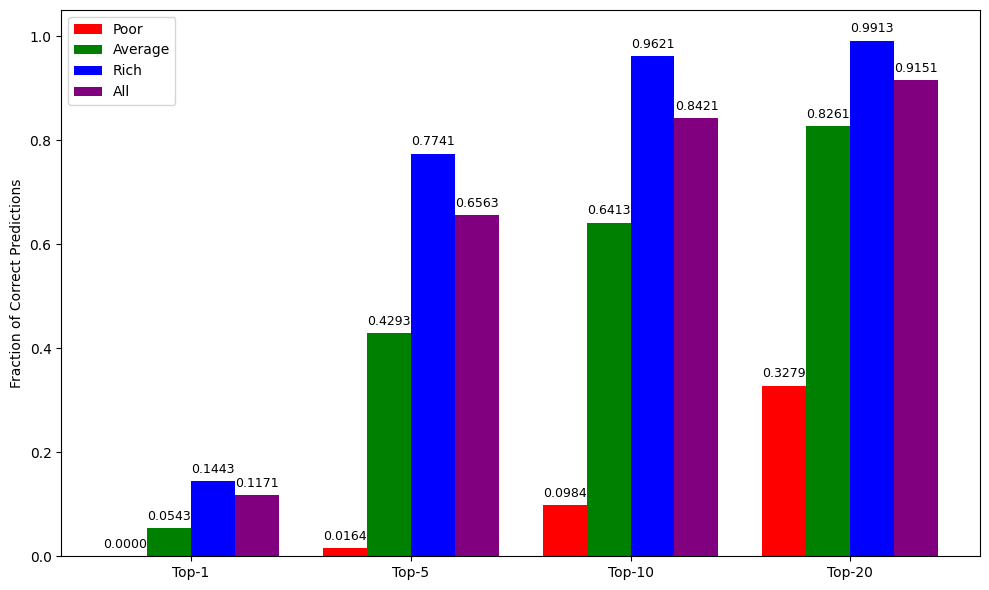

In [ ]:
d = dataset.copy()

node2vec = Node2Vec(G, dimensions=16, walk_length=80, num_walks=120, workers=4, seed=42)
model = node2vec.fit(window=10, min_count=1, batch_words=32)

def add_embeddings(df):
    df['p_emb'] = df['Phosphatase'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(16))
    df['s_emb'] = df['Substrate'].apply(lambda x: model.wv[x] if x in model.wv else np.zeros(16))
    return df

def category(df):
    # Count unique substrates for each phosphatase where label == 1
    counts = df[df['label'] == 1].groupby('Phosphatase')['Substrate'].nunique()
    c = {}
    for phosphatase, count in counts.items():
        if count <= 3:
            c[phosphatase] = 'poor'
        elif count <= 15:
            c[phosphatase] = 'average'
        else:
            c[phosphatase] = 'rich'
    return c

def loocv(df):
    phosphatase_category = category(df)
    all_phosphatases = df['Phosphatase'].unique()
    results = {'poor': [], 'average': [], 'rich': [], 'all': []}

    for i in range(len(df)):
        test_row = df.iloc[i]
        test_p = test_row['Phosphatase']
        test_s = test_row['Substrate']
        test_label = test_row['label']

        train_df = df.drop(i).reset_index(drop=True)
        train_df = add_embeddings(train_df)

        X_train = np.stack(train_df.apply(lambda row: np.concatenate([row['p_emb'], row['s_emb']]), axis=1))
        y_train = train_df['label'].values

        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)

        test_candidates = pd.DataFrame({'Phosphatase': all_phosphatases, 'Substrate': test_s})
        test_candidates = add_embeddings(test_candidates)
        X_test = np.stack(test_candidates.apply(lambda row: np.concatenate([row['p_emb'], row['s_emb']]), axis=1))

        probs = clf.predict_proba(X_test)[:, 1]
        ranked = [p for p, _ in sorted(zip(all_phosphatases, probs), key=lambda x: x[1], reverse=True)]

        if test_label == 1:
            rank = ranked.index(test_p) + 1
            cat = phosphatase_category.get(test_p)
            if cat:
                results[cat].append(rank)
            results['all'].append(rank)  # Add rank to 'all' category

    return results, phosphatase_category

results, phosphatase_category = loocv(d)

# Count phosphatases in each category
category_counts = Counter(phosphatase_category.values())
print("\nNumber of phosphatases in each category:")
for cat in ['poor', 'average', 'rich']:
    print(f"{cat.capitalize()}: {category_counts[cat]}")

# Count how many phosphatases are in 'all' category
all_phosphatases_in_all_category = len(results['all'])
print(f"\'all': {all_phosphatases_in_all_category}")

top_k_results = {
    'Top-1': {cat: np.mean([r <= 1 for r in results[cat]]) for cat in ['poor', 'average', 'rich', 'all']},
    'Top-5': {cat: np.mean([r <= 5 for r in results[cat]]) for cat in ['poor', 'average', 'rich', 'all']},
    'Top-10': {cat: np.mean([r <= 10 for r in results[cat]]) for cat in ['poor', 'average', 'rich', 'all']},
    'Top-20': {cat: np.mean([r <= 20 for r in results[cat]]) for cat in ['poor', 'average', 'rich', 'all']},
}

print("\nTop-K Accuracy by Category:")
for k in ['Top-1', 'Top-5', 'Top-10', 'Top-20']:
    print(f"\n{k} Accuracy:")
    for cat in ['poor', 'average', 'rich', 'all']:
        print(f"  {cat.capitalize()}: {top_k_results[k][cat]:.4f}")

def plot_single_bar_chart(top_k_results):
    top_k_labels = ['Top-1', 'Top-5', 'Top-10', 'Top-20']
    categories = ['poor', 'average', 'rich', 'all']
    colors = {'poor': 'red', 'average': 'green', 'rich': 'blue', 'all': 'purple'}

    x = np.arange(len(top_k_labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, cat in enumerate(categories):
        values = [top_k_results[label][cat] for label in top_k_labels]
        ax.bar(x + (i - 1.5) * width, values, width=width, label=cat.capitalize(), color=colors[cat])
        for j, val in enumerate(values):
            ax.text(x[j] + (i - 1.5) * width, val + 0.01, f"{val:.4f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(top_k_labels)
    ax.set_ylabel("Fraction of Correct Predictions")
    ax.set_ylim(0, 1.05)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_single_bar_chart(top_k_results)